In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import IPython.display as display
import PIL.Image




In [2]:
from tensorflow.keras.preprocessing import image

In [3]:
#图像标准化
def normalize_image(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img , tf.uint8)

In [4]:
#可视化函数
def show_image(img):
    display.display(PIL.Image.fromarray(np.array(img)))

In [5]:
#保存图像
def save_image(img):
    PIL.Image.fromarray(np.array(img)).save(file_name)

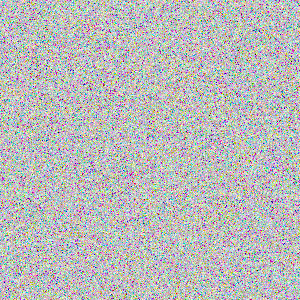

In [6]:
#生成噪音图像
img_noise = np.random.uniform(size = (300 , 300 ,3)) + 500.0  #+100 提高亮度
img_noise = img_noise.astype(np.float32)
show_image(normalize_image(img_noise))

In [7]:
#加载模型
base_model = tf.keras.applications.InceptionV3(include_top = False ,
                                              weights = 'imagenet')

In [8]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
#选择卷积层通道
layer_names = 'conv2d_85'
layer = base_model.get_layer(layer_names).output

In [10]:
layer

<tf.Tensor 'conv2d_85/Identity:0' shape=(None, None, None, 320) dtype=float32>

In [11]:
#创建特征提取模型
dream_model = tf.keras.Model(inputs = base_model.input , outputs = layer)


In [12]:
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#计算损失
def calc_loss(img , model):
    channel = 13
    img = tf.expand_dims(img , axis = 0)
    layer_activations = model(img)
    act = layer_activations[: , : , : ,channel]
    loss = tf.math.reduce_mean(act)
    return loss

In [14]:
#图像优化
def render_deepdream(model , img , steps = 300 , step_size=0.01 , verbose = 1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss(img , model)
        gradients = tape.gradient(loss , img)
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        img = img + gradients * step_size
        img = tf.clip_by_value(img , -1 , 1)
        
        if(verbose == 1):
            if ((n + 1) % 10 == 0):
                print("step {} / {} , loss {}".format(n+1 , steps , loss))
    return img

In [15]:
#图像预处理
img = tf.keras.applications.inception_v3.preprocess_input(img_noise)
img = tf.convert_to_tensor(img)

开始depp dream
step 10 / 3000 , loss 0.486287921667099
step 20 / 3000 , loss 0.8736211061477661
step 30 / 3000 , loss 0.9406125545501709
step 40 / 3000 , loss 1.4185243844985962
step 50 / 3000 , loss 1.4546282291412354
step 60 / 3000 , loss 1.947568416595459
step 70 / 3000 , loss 2.016024351119995
step 80 / 3000 , loss 2.037961483001709
step 90 / 3000 , loss 2.398721694946289
step 100 / 3000 , loss 2.5899229049682617
step 110 / 3000 , loss 2.722792148590088
step 120 / 3000 , loss 2.9417552947998047
step 130 / 3000 , loss 3.0468204021453857
step 140 / 3000 , loss 3.2046236991882324
step 150 / 3000 , loss 3.133850574493408
step 160 / 3000 , loss 3.5060982704162598
step 170 / 3000 , loss 3.4921679496765137
step 180 / 3000 , loss 3.6129934787750244
step 190 / 3000 , loss 3.674872398376465
step 200 / 3000 , loss 3.7767629623413086
step 210 / 3000 , loss 3.8744137287139893
step 220 / 3000 , loss 3.922067642211914
step 230 / 3000 , loss 4.035161972045898
step 240 / 3000 , loss 4.092020988464355

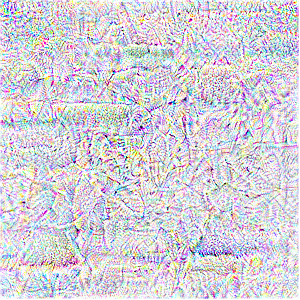

In [17]:
#开始处理
import time
start = time.time()
print("开始depp dream")

dream_img = render_deepdream(dream_model , img , steps = 3000 , step_size = 0.01)

end = time.time()
end-start
print("结束")

dream_img = normalize_image(dream_img)

show_image(dream_img)

file_name = 'deepdream_{}.jpg'.format(layer_names)
save_image(dream_img)
